# **Restoration**
### by Yixuan Du (yd271@georgetown.edu), Neuman Alkhalil (na892@georgetown.edu), and Chriss Jordan Oboa (cfo17@georgetown.edu)**

In [ ]:
#import part
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from skimage.color import rgb2lab, lab2rgb
from skimage import color
import torch.optim as optim
import os
from torchvision.datasets import CIFAR10
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import zipfile
import cv2
import random



In [ ]:
WORKDIR = "/content/sample_data"

### **DATA PART**

In [ ]:
#unzip the dataset
#link to the drive: https://drive.google.com/file/d/1j2r0rRfmLBxMfeKktduukMdj946U_dSN/view?usp=share_link
#need to download the zip file and upload it to your drive
zip_path = '/content/drive/MyDrive/ffhq.zip'
extraction_path = '/content/ffhq'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 14505 pixels
  return func(*args, **kwargs)


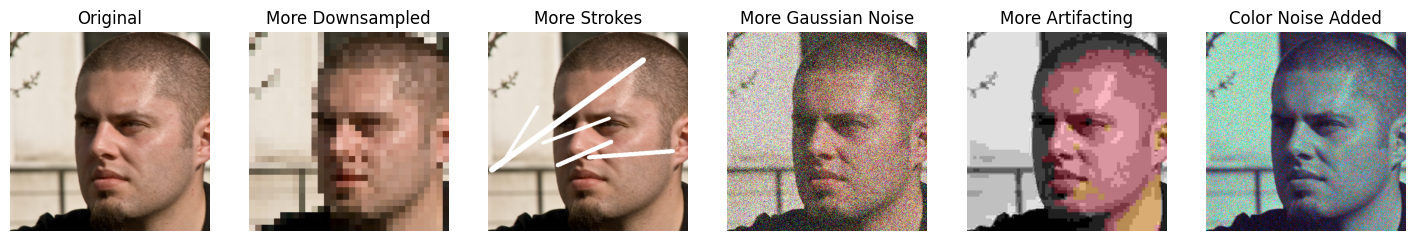

In [ ]:
extraction_path = '/content/ffhq/ffhq/original'

image_files = os.listdir(extraction_path)
image_path = os.path.join(extraction_path, image_files[0])

image = Image.open(image_path)


image_np = np.array(image)

#Apply different types of noise

## Add random strokes
def add_strokes(image, num_strokes=5):
    for _ in range(num_strokes):
        start_point = (random.randint(0, image.shape[1]), random.randint(0, image.shape[0]))
        end_point = (random.randint(0, image.shape[1]), random.randint(0, image.shape[0]))
        thickness = random.randint(1, 20)
        # color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        color = (255, 255, 255) #RGB value for white
        cv2.line(image, start_point, end_point, color, thickness)
    return image

## Increase downsampling by reducing to a smaller size
def apply_downsampling(image_np, downscale_factor=32, original_size=(512, 512)):

    downsampled = cv2.resize(image_np, (downscale_factor, downscale_factor), interpolation=cv2.INTER_LINEAR)
    return cv2.resize(downsampled, original_size, interpolation=cv2.INTER_NEAREST)

## Adding more Gaussian Noise
def add_gaussian_noise(image_np, variance=10000):
    mean = 0
    sigma = variance ** 0.5
    gaussian = np.random.normal(mean, sigma, image_np.shape)
    noisy_image = np.clip(image_np + gaussian, 0, 255).astype(np.uint8)
    return noisy_image

## More Artifacting - Decrease JPEG quality further
def add_compression_artifacts(image_np, quality=1):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, encoded_img = cv2.imencode('.jpg', image_np, encode_param)
    decoded_img = cv2.imdecode(encoded_img, 1)
    return decoded_img

# Making images grayscale and adding noise to the other 2 channels
def add_color_noise(image_np):

    lab_image = color.rgb2lab(image_np)
    X = lab_image[:, :, 0]
    Y = lab_image[:, :, 1:]
    X = torch.from_numpy(X).unsqueeze(2)
    Y = torch.from_numpy(Y)
    noise = torch.randn_like(Y)*64
    X_ = torch.cat([X, noise], dim=2)

    noisy_rgb = color.lab2rgb(X_)
    noisy_rgb = (noisy_rgb * 255).astype(np.uint8)
    return noisy_rgb



## Demonstrating functions on 1 image
stroke = image_np.copy()
stroke = add_strokes(stroke, num_strokes=random.randint(5, 15))
downsampled = image_np.copy()
downsampled = apply_downsampling(downsampled)
gaussian_noise = image_np.copy()
gaussian_noise = add_gaussian_noise(gaussian_noise)
artifacted = image_np.copy()
artifacted = add_compression_artifacts(artifacted)
color_noise_img = add_color_noise(image_np)


## Display the images
fig, ax = plt.subplots(1, 6, figsize=(18, 3))
ax[0].imshow(image_np)
ax[0].set_title('Original')
ax[1].imshow(downsampled)
ax[1].set_title('More Downsampled')
ax[2].imshow(stroke)
ax[2].set_title('More Strokes')
ax[3].imshow(gaussian_noise)
ax[3].set_title('More Gaussian Noise')
ax[4].imshow(artifacted)
ax[4].set_title('More Artifacting')
ax[5].imshow(color_noise_img)
ax[5].set_title('Color Noise Added')
for a in ax:
    a.axis('off')
plt.show()

In [ ]:
# Create Folders for Augmented Images
augmentation_types = ['original', 'downsampled', 'strokes', 'gaussian_noise', 'artifacted']
for aug_type in augmentation_types:
    os.makedirs(os.path.join(extraction_path, aug_type), exist_ok=True)

In [ ]:
#Here to preprocess the pictures
for i, file_name in enumerate(image_files[:10000]):
    if not file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    image_path = os.path.join(extraction_path, file_name)
    image = Image.open(image_path)
    image_np = np.array(image)


    Image.fromarray(image_np).save(os.path.join(extraction_path, 'original', file_name))


    aug_functions = {
        'downsampled': apply_downsampling,
        'strokes': lambda img: add_strokes(img, num_strokes=random.randint(5, 15)),
        'gaussian_noise': add_gaussian_noise,
        'artifacted': add_compression_artifacts,
    }
    for aug_name, aug_func in aug_functions.items():
        augmented_image_np = image_np.copy()
        augmented_image = aug_func(augmented_image_np)
        Image.fromarray(augmented_image).save(os.path.join(extraction_path, aug_name, file_name))

    if i % 100 == 0:
        print(f"Processed {i} images...")

print("Done processing 10000 images.")

In [ ]:
#colorization pictures
extraction_path = '/content/ffhq/ffhq/original'
output_path = '/content/ffhq/ffhq/color_noise'

In [ ]:
def apply_color_noise_to_images(input_folder, output_folder):
    image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for i, file_name in enumerate(image_files):
        image_path = os.path.join(input_folder, file_name)
        image = Image.open(image_path).convert('RGB')
        image_np = np.array(image)


        color_noised_image = add_color_noise(image_np)


        Image.fromarray(color_noised_image).save(os.path.join(output_folder, file_name))

        if i % 100 == 0:
            print(f"Processed {i} images...")

    print("Done processing all images.")


apply_color_noise_to_images(extraction_path, output_path)


In [ ]:
num_files = len([name for name in os.listdir(extraction_path) if os.path.isfile(os.path.join(extraction_path, name))])
print(f"There are {num_files} files in the folder.")

There are 10000 files in the folder.


In [ ]:
#DO NOT NEED TO RUN THIS UNLESS YOU WANT TO STORE IN YOUR DRIVE!

# Copy from here to Drive
destination_root = '/content/drive/MyDrive/GANs_Restoration_Images'
augmentation_types = ['original', 'downsampled', 'strokes', 'gaussian_noise', 'artifacted']

for aug_type in augmentation_types:
    source_folder = os.path.join(extraction_path, aug_type)
    destination_folder = os.path.join(destination_root, aug_type)
    !cp -r "{source_folder}" "{destination_folder}"
    print(f"Copied {aug_type} to Google Drive.")

^C
Copied original to Google Drive.
^C
Copied downsampled to Google Drive.
Copied strokes to Google Drive.
Copied gaussian_noise to Google Drive.
Copied artifacted to Google Drive.


In [ ]:
#DO NOT NEED TO RUN THIS UNLESS YOU WANT TO import from YOUR DRIVE!

# Copy from Drive to here
drive_path = '/content/drive/MyDrive/GANs_Restoration_Images'
destination_root = '/content/ffhq'
augmentation_types = ['original', 'downsampled', 'strokes', 'gaussian_noise', 'artifacted']

for aug_type in augmentation_types:
    source_folder = os.path.join(drive_path, aug_type)
    destination_folder = os.path.join(destination_root, aug_type)
    !cp -r "{source_folder}" "{destination_folder}"
    print(f"Copied {aug_type} to Google Drive.")

Copied original to Google Drive.
Copied downsampled to Google Drive.
Copied strokes to Google Drive.
Copied gaussian_noise to Google Drive.
Copied artifacted to Google Drive.


In [ ]:
#dataset
class MixedNoiseDataset(Dataset):
    def __init__(self, clean_dir, noisy_dirs, transform=None):
        """
        Args:
            clean_dir (string): Directory with all the clean images.
            noisy_dirs (list): List of directories with the noisy images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.clean_dir = clean_dir
        self.noisy_dirs = noisy_dirs
        self.transform = transform
        self.images = os.listdir(clean_dir)
        self.noisy_images = []
        for noisy_dir in noisy_dirs:
            for img_name in os.listdir(noisy_dir):
                self.noisy_images.append((img_name, noisy_dir))

    def __len__(self):
        return len(self.noisy_images)

    def __getitem__(self, idx):
        img_name, noisy_dir = self.noisy_images[idx]
        clean_img_path = os.path.join(self.clean_dir, img_name)
        noisy_img_path = os.path.join(noisy_dir, img_name)

        clean_img = Image.open(clean_img_path).convert('RGB')
        noisy_img = Image.open(noisy_img_path).convert('RGB')

        if self.transform:
            clean_img = self.transform(clean_img)
            noisy_img = self.transform(noisy_img)

        return noisy_img, clean_img

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512)),
])

clean_dir = '/content/ffhq/ffhq/original'
noisy_dirs = [
    '/content/ffhq/ffhq/artifacted',
    '/content/ffhq/ffhq/downsampled',
    '/content/ffhq/ffhq/gaussian_noise',
    '/content/ffhq/ffhq/strokes',
    '/content/ffhq/ffhq/color_noise',
]

dataset = MixedNoiseDataset(clean_dir=clean_dir, noisy_dirs=noisy_dirs, transform=transform)

dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

# **Model Part**

**Generator Model in PyTorch**

In [ ]:
# Downsample
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, apply_batchnorm=True):
        super(Downsample, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels) if apply_batchnorm else None
        self.leakyrelu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm is not None:
            x = self.batchnorm(x)
        x = self.leakyrelu(x)
        return x

# Upsample
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, apply_dropout=False):
        super(Upsample, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(0.5) if apply_dropout else None
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.deconv(x)
        x = self.batchnorm(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = self.relu(x)
        return x

class AutoencoderGenerator1(nn.Module):
    def __init__(self):
        super(AutoencoderGenerator1, self).__init__()
        self.downstack = nn.ModuleList([
            Downsample(3, 32, 4, apply_batchnorm=True),
            Downsample(32, 64, 4,apply_batchnorm=True),
            Downsample(64, 128, 4,apply_batchnorm=True),
            Downsample(128, 256, 4,apply_batchnorm=True),
            Downsample(256, 256, 4,apply_batchnorm=True),
            Downsample(256, 256, 4,apply_batchnorm=True),
        ])

        self.upstack = nn.ModuleList([
            Upsample(256, 256, 4, apply_dropout=True),
            Upsample(512, 256, 4),
            Upsample(512, 128, 4),
            Upsample(256, 64, 4),
            Upsample(128, 32, 4),

        ])
        self.Upsample = Upsample(64, 3, 4)

        self.tanh = nn.Tanh()

    def forward(self, x):

        skips = []
        for down in self.downstack:
            x = down(x)
            skips.append(x)
        skips = reversed(skips[:-1])

        for up, skip in zip(self.upstack, skips):

            x = up(x)

            x = torch.cat((x, skip), 1)




        x = self.Upsample(x)

        x = self.tanh(x)

        return x


**Discriminator model**

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ZeroPad2d((0, 1, 0, 1)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(128, 256, 3, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(1016064, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        return self.conv_layers(img)

**Loss Function**

In [ ]:
LAMBDA = 10

# Binary Cross Entropy Loss for discriminator
bce_loss = nn.BCEWithLogitsLoss()

def discriminator_loss(disc_real_output, disc_generated_output):

    real_loss = bce_loss(disc_real_output, torch.ones_like(disc_real_output))

    generated_loss = bce_loss(disc_generated_output, torch.zeros_like(disc_generated_output))

    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):

    gan_loss = bce_loss(disc_generated_output, torch.ones_like(disc_generated_output))

    l1_loss = torch.mean(torch.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss


**Model initialization and optimizer setup**

In [ ]:
generator = AutoencoderGenerator1()
discriminator = Discriminator()

# Initialize optimizers
generator_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Set up checkpoint directory
checkpoint_dir = os.path.join(WORKDIR, 'training-checkpoints')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
if not os.path.exists(checkpoint_prefix):
    os.makedirs(checkpoint_prefix)
drive_path = "/content/drive/MyDrive/GANs_Restoration_Images"

writer = SummaryWriter(checkpoint_dir)

# Save and Load Functions
def save_checkpoint(epoch):
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'generator_optimizer_state_dict': generator_optimizer.state_dict(),
        'discriminator_optimizer_state_dict': discriminator_optimizer.state_dict(),
    }, os.path.join(checkpoint_prefix, f"epoch_{epoch}.pth"))
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'generator_optimizer_state_dict': generator_optimizer.state_dict(),
        'discriminator_optimizer_state_dict': discriminator_optimizer.state_dict(),
    }, os.path.join(drive_path, f"epoch_{epoch}.pth"))

def load_checkpoint(epoch, device):
    checkpoint = torch.load(os.path.join(checkpoint_prefix, f"epoch_{epoch}.pth"), map_location=device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    generator_optimizer.load_state_dict(checkpoint['generator_optimizer_state_dict'])
    discriminator_optimizer.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])
    return checkpoint['epoch']


# **Training part**

In [ ]:
#Use it if you want to train. However, trained epoch link is provided below. Just follow the steps
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_epoch = 102
load_checkpoint(load_epoch, device)
def train(dataloader, generator, discriminator, g_optimizer, d_optimizer, g_loss_func, d_loss_func, num_epochs):
    generator.to(device)
    discriminator.to(device)

    for epoch in range(load_epoch + 1, num_epochs):
        for i, (noisy_imgs, clean_imgs) in enumerate(dataloader):
            noisy_imgs = noisy_imgs.to(device)
            clean_imgs = clean_imgs.to(device)
            # print(clean_imgs.shape)

            # Train Discriminator
            d_optimizer.zero_grad()

            fake_images = generator(noisy_imgs).detach()
            # print(fake_images.shape)
            real_pred = discriminator(clean_imgs)
            fake_pred = discriminator(fake_images)
            d_loss = d_loss_func(real_pred, fake_pred)
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            generator.train()  # In case generator has dropout or batchnorm layers that behave differently during training
            fake_images = generator(noisy_imgs)
            g_optimizer.zero_grad()
            fake_pred = discriminator(fake_images)
            g_loss, gan_loss, l1_loss = g_loss_func(fake_pred, fake_images, clean_imgs)
            g_loss.backward()
            g_optimizer.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], "
                      f"Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}")

        # Save checkpoint
        save_checkpoint(epoch)

#change the number of epoch below
train(dataloader, generator, discriminator, generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss, num_epochs=135)


Epoch [104/135], Step [1/6250], Generator Loss: 0.5811, Discriminator Loss: 1.6265
Epoch [104/135], Step [101/6250], Generator Loss: 0.6623, Discriminator Loss: 1.6265
Epoch [104/135], Step [201/6250], Generator Loss: 0.6526, Discriminator Loss: 1.6265
Epoch [104/135], Step [301/6250], Generator Loss: 0.6775, Discriminator Loss: 1.6265
Epoch [104/135], Step [401/6250], Generator Loss: 0.5852, Discriminator Loss: 1.6265
Epoch [104/135], Step [501/6250], Generator Loss: 0.5757, Discriminator Loss: 1.6265
Epoch [104/135], Step [601/6250], Generator Loss: 0.7222, Discriminator Loss: 1.6265
Epoch [104/135], Step [701/6250], Generator Loss: 0.6430, Discriminator Loss: 1.6265
Epoch [104/135], Step [801/6250], Generator Loss: 0.5744, Discriminator Loss: 1.6265
Epoch [104/135], Step [901/6250], Generator Loss: 0.6555, Discriminator Loss: 1.6265
Epoch [104/135], Step [1001/6250], Generator Loss: 0.5995, Discriminator Loss: 1.6265
Epoch [104/135], Step [1101/6250], Generator Loss: 0.6437, Discrim

KeyboardInterrupt: 

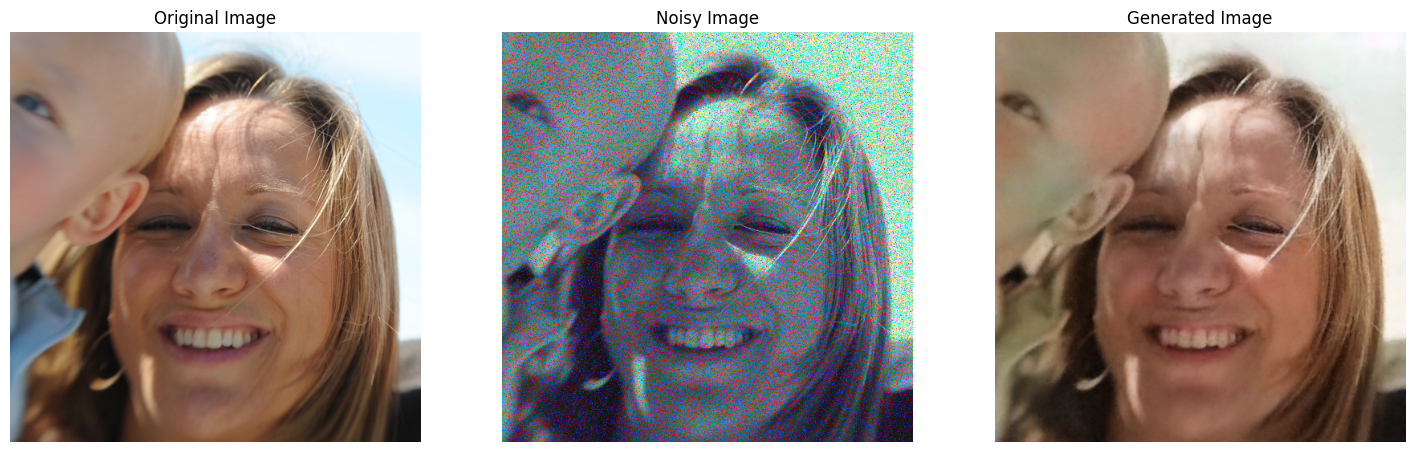

In [ ]:
#Trained epoch that we used to run are stored here: https://drive.google.com/drive/folders/1tLEouXq7uYD-qKaJVQNB7oEA6Ncahdu5?usp=sharing
#download it to your computer then upload it to your collab in /content/sample_data/training-checkpoints/ckpt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#change to match epoch number to be tested on
load_epoch = 103
load_checkpoint(load_epoch, device)

def test_model(dataloader):
    generator.eval()

    with torch.no_grad():
        for i, (X, Y) in enumerate(dataloader):
            if i == 0:
                X = X.to(device)


                fake_images = generator(X)


                plt.figure(figsize=(18, 6))
                plt.subplot(1, 3, 1)
                plt.imshow(np.transpose(Y[0], (1, 2, 0)))

                plt.title('Original Image')
                plt.axis('off')
                X = X.to('cpu')

                plt.subplot(1, 3, 2)
                plt.imshow(np.transpose(X[0], (1, 2, 0)))
                plt.title('Noisy Image')
                plt.axis('off')
                fake_images=fake_images.to('cpu')

                plt.subplot(1, 3, 3)
                plt.imshow(np.transpose(fake_images[0], (1, 2, 0)))
                plt.title('Generated Image')
                plt.axis('off')


                plt.show()
                break

test_model(dataloader)


TESTING ON REAL old BLACK AND WHITE PICTURES

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 30010 pixels
  return func(*args, **kwargs)


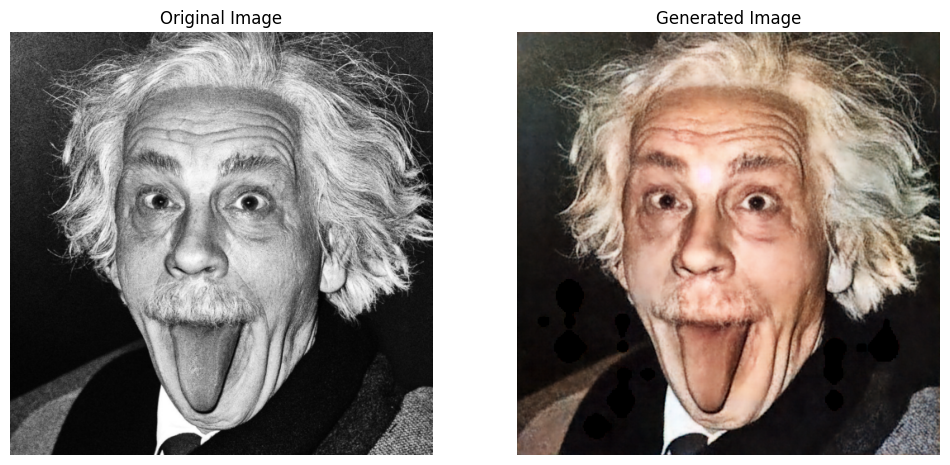

In [ ]:
#Here is just to test colorization on external black and white picture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_checkpoint(94, device)
generator = generator.to(device)
generator.eval()

def load_image(image_path):
    # Load image
    image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB format


    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ])


    image = transform(image)
    image_ = image.permute(1,2,0)
    lab_image = color.rgb2lab(image_)

    X = lab_image[:, :, 0]
    Y = lab_image[:, :, 1:]
    X = torch.from_numpy(X).unsqueeze(2)

    Y = torch.from_numpy(Y)

    noise = torch.randn_like(Y)*64

    X_ = torch.cat([X, noise], dim=2)


    noisy_rgb = color.lab2rgb(X_)
    return image, torch.from_numpy(noisy_rgb).unsqueeze(0).permute(0,3,1,2)

def test_single_image(ori_image, image_tensor):
    with torch.no_grad():
        image_tensor = image_tensor.to(device)

        fake_images = generator(image_tensor)


        original_image = ori_image.to('cpu').squeeze(0).permute(1, 2, 0)
        fake_image = fake_images.to('cpu').squeeze(0).permute(1, 2, 0)


        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(fake_image)
        plt.title('Generated Image')
        plt.axis('off')

        plt.show()

#change image path. Use your drive to get the needed picture to test on
image_path = '/content/drive/MyDrive/pictures/Albert.jpg'
ori_image,image_tensor = load_image(image_path)


test_single_image(ori_image, image_tensor)